<img src="http://hilpisch.com/tpq_logo.png" alt="The Python Quants" width="45%" align="right" border="4">

# Interest Rate Swaps

*Very nascent*.

Interest rate swaps are a first step towards including **rate-sensitive instruments** in the modeling and valuation spectrum of DX Analytics. The model used in the following is the **square-root diffusion process** by Cox-Ingersoll-Ross (1985). Data used are UK/London OIS and Libor rates.

In [1]:
import dx
import time
import numpy as np
import pandas as pd
import datetime as dt
from pylab import plt
plt.style.use('seaborn')
%matplotlib inline

## OIS Data & Discounting

We start by importing **OIS term structure data** (source: http://www.bankofengland.co.uk) for risk-free discounting. We also adjust the data structure somewhat for our purposes.

In [115]:
# UK OIS Spot Rates Yield Curve
oiss = pd.read_excel('Data.xls', 'Sheet1',index_col=0)

# use years as index
oiss = oiss.T
# del oiss['years']
oiss.head(4)

Date,20110328,20110329,20110330,20110331,20110401,20110404,20110405,20110406,20110407,20110408,...,20140314,20140317,20140318,20140319,20140320,20140321,20140324,20140325,20140326,20140327
1D,0.116631,0.099386,0.110544,0.155185,0.113587,0.031433,0.020279,0.082142,0.084170,0.064899,...,0.075042,0.098371,0.091271,0.067942,0.075042,0.068956,0.070985,0.070985,0.060843,0.061857
7D,0.192728,0.192728,0.192728,0.202877,0.192728,0.152139,0.152139,0.152139,0.152139,0.141993,...,0.101414,0.101414,0.101414,0.081127,0.081127,0.081127,0.091270,0.091270,0.091270,0.091270
14D,0.213021,0.213021,0.213021,0.213021,0.213021,0.182577,0.172430,0.152137,0.152137,0.150614,...,0.101413,0.101413,0.101413,0.101413,0.101413,0.101413,0.101413,0.101413,0.101413,0.101413
1M,0.047608,0.069371,0.037302,0.067656,0.041858,0.017887,0.036548,0.034491,0.028678,0.028236,...,0.055359,0.052272,0.053673,0.067715,0.061275,0.052893,0.046209,0.050556,0.046448,0.021751


In [116]:
# only date information for columns, no time
oiss.columns = [dt.date(year=int(str(d)[0:4]),month=int(str(d)[4:6]),day=int(str(d)[6:8])) for d in oiss.columns]
startdate = dt.date(year=2013,month=6,day=12)
rows_front = [startdate + dt.timedelta(days=int(d[:-1])) for d in oiss.index if d[-1]=='D']
rows_end = [startdate + dt.timedelta(days=int(int(d[:-1])*30.42)) for d in oiss.index if d[-1]=='M']
rows_end = [d.replace(day=12) for d in rows_end]
rows_front.extend(rows_end)
oiss.index = rows_front

In [132]:
oiss.tail()

,2011-03-28,2011-03-29,2011-03-30,2011-03-31,2011-04-01,2011-04-04,2011-04-05,2011-04-06,2011-04-07,2011-04-08,...,2014-03-14,2014-03-17,2014-03-18,2014-03-19,2014-03-20,2014-03-21,2014-03-24,2014-03-25,2014-03-26,2014-03-27
2022-06-12,3.443817,3.494568,3.449966,3.478114,3.457128,3.434650,3.497334,3.560921,3.557812,3.588443,...,2.621606,2.664075,2.642630,2.748921,2.749545,2.723628,2.712922,2.732028,2.674293,2.664159
2023-06-12,3.620892,3.670063,3.627662,3.647803,3.628087,3.610791,3.670840,3.736715,3.740334,3.773317,...,2.771728,2.814819,2.793481,2.888790,2.889516,2.857203,2.839629,2.862171,2.803561,2.788794
2028-06-12,4.278242,4.322819,4.289884,4.293690,4.270746,4.262502,4.300284,4.384716,4.404489,4.434284,...,3.325236,3.363567,3.344962,3.405641,3.411700,3.361704,3.324028,3.352611,3.297341,3.280543
2033-06-12,4.607711,4.649981,4.621802,4.617402,4.592835,4.589139,4.615734,4.709488,4.737378,4.765572,...,3.602556,3.638497,3.621265,3.664560,3.673296,3.614426,3.566660,3.598275,3.544682,3.526865
2043-06-12,4.937713,4.977667,4.954259,4.941627,4.915433,4.916299,4.931672,5.034777,5.070810,5.097396,...,3.880254,3.913800,3.897944,3.923809,3.935228,3.867461,3.809583,3.844236,3.792323,3.773486


Next we replace the **year fraction index** by a **DatetimeIndex**.

In [123]:
oiss[startdate]

2013-06-13    0.053743
2013-06-19    0.091270
2013-06-26    0.111556
2013-07-12    0.039207
2013-09-12    0.048226
2013-12-12    0.080860
2014-06-12    0.141550
2015-06-12    0.341575
2016-06-12    0.578743
2017-06-12    0.942032
2018-06-12    1.167832
2020-06-12    1.675424
2022-06-12    2.142639
2023-06-12    2.310202
2028-06-12    2.978568
2033-06-12    3.313579
2043-06-12    3.649143
Name: 2013-06-12, dtype: float64

Let us have a look at the **most current data**, i.e. the term structure, of the data set.

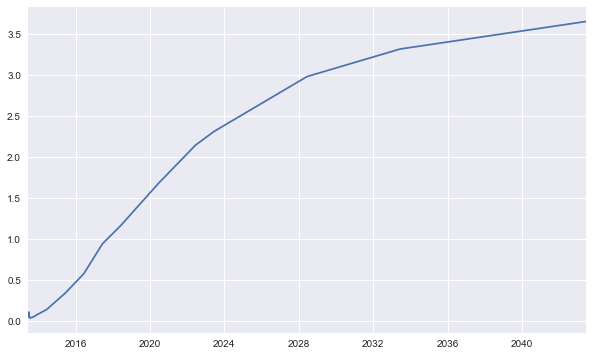

In [122]:
oiss[startdate].plot(figsize=(10, 6))

This data is used to instantiate a `deterministic_short_rate` **model for risk-neutral discounting** purposes.

In [124]:
# generate deterministic short rate model based on UK OIS curve
ois = dx.deterministic_short_rate('ois', list(zip(oiss.index, oiss[startdate].values / 100)))

In [125]:
# example dates and corresponding discount factors
dr = pd.date_range('2015-1', periods=4, freq='6m').to_pydatetime()
ois.get_discount_factors(dr)[::-1]

([0.9965401658643362, 0.9967529049547326, 0.9977479849065692, 1.0],
 array([datetime.datetime(2015, 1, 31, 0, 0),
        datetime.datetime(2015, 7, 31, 0, 0),
        datetime.datetime(2016, 1, 31, 0, 0),
        datetime.datetime(2016, 7, 31, 0, 0)], dtype=object))

## Libor Market Data

We want to model a **3 month Libor-based interest rate swap**. To this end, we need Libor term structure data, i.e. forward rates in this case (source: http://www.bankofengland.co.uk), to calibrate the  valuation to. The data importing and adjustments are the same as before.

In [129]:
# UK Libor foward rates
libf = pd.read_excel('Data.xls', 'Sheet2',index_col=0)
# use years as index
libf = libf.T
# del oiss['years']
libf.head(4)

Date,20110328,20110329,20110330,20110331,20110401,20110404,20110405,20110406,20110407,20110408,...,20140314,20140317,20140318,20140319,20140320,20140321,20140324,20140325,20140326,20140327
1D,0.194761,0.191716,0.188164,0.187150,0.186642,0.180756,0.172131,0.165129,0.159244,0.156961,...,0.089039,0.089851,0.089749,0.090256,0.089749,0.091778,0.091575,0.091676,0.091575,0.092082
7D,0.226075,0.224770,0.221914,0.221334,0.220827,0.215810,0.209140,0.204660,0.199426,0.195881,...,0.118123,0.116934,0.118268,0.119818,0.117137,0.117210,0.116963,0.116326,0.119789,0.119862
14D,0.234300,0.233865,0.231248,0.230886,0.230378,0.225615,0.218927,0.215020,0.211507,0.207821,...,0.137016,0.136246,0.137231,0.138448,0.135562,0.135471,0.135338,0.134756,0.136294,0.136096
1M,0.248115,0.246904,0.244467,0.243685,0.243178,0.239841,0.235050,0.232698,0.230285,0.225529,...,0.154605,0.154321,0.154909,0.155758,0.152749,0.152569,0.152550,0.152049,0.151556,0.151107


In [130]:
# only date information for columns, no time
# only date information for columns, no time
libf.columns = [dt.date(year=int(str(d)[0:4]),month=int(str(d)[4:6]),day=int(str(d)[6:8])) for d in libf.columns]

startdate = dt.date(year=2013,month=6,day=12)
rows_front = [startdate + dt.timedelta(days=int(d[:-1])) for d in libf.index if d[-1]=='D']
rows_end = [startdate + dt.timedelta(days=int(int(d[:-1])*30.42)) for d in libf.index if d[-1]=='M']
rows_end = [d.replace(day=12) for d in rows_end]
rows_front.extend(rows_end)
libf.index = rows_front

In [131]:
libf.tail()

,2011-03-28,2011-03-29,2011-03-30,2011-03-31,2011-04-01,2011-04-04,2011-04-05,2011-04-06,2011-04-07,2011-04-08,...,2014-03-14,2014-03-17,2014-03-18,2014-03-19,2014-03-20,2014-03-21,2014-03-24,2014-03-25,2014-03-26,2014-03-27
2025-06-12,3.946211,3.991168,3.940979,3.957771,3.936970,3.920749,3.986839,4.047366,4.049675,4.093499,...,3.154384,3.195119,3.177213,3.258207,3.270487,3.216301,3.201786,3.220832,3.166032,3.148253
2028-06-12,4.212965,4.257854,4.210624,4.220559,4.198030,4.186069,4.241924,4.308403,4.320624,4.361087,...,3.422931,3.466617,3.453785,3.519178,3.524917,3.462920,3.438177,3.462460,3.404623,3.387058
2033-06-12,4.400315,4.447272,4.404166,4.403129,4.384845,4.376607,4.422875,4.495401,4.511886,4.548469,...,3.657118,3.690987,3.673582,3.731050,3.738374,3.665497,3.628645,3.659810,3.607342,3.588732
2038-06-12,4.472191,4.516122,4.479049,4.471928,4.455399,4.449576,4.488417,4.564735,4.584465,4.616751,...,3.735279,3.769451,3.756961,3.799469,3.814702,3.732244,3.687853,3.721334,3.673535,3.654392
2043-06-12,4.520046,4.561956,4.528907,4.517731,4.502372,4.498159,4.532049,4.610894,4.632788,4.662209,...,3.787365,3.821745,3.812541,3.845057,3.865573,3.776719,3.727298,3.762322,3.717641,3.698142


And the short end of the **Libor term sturcture** visualized.

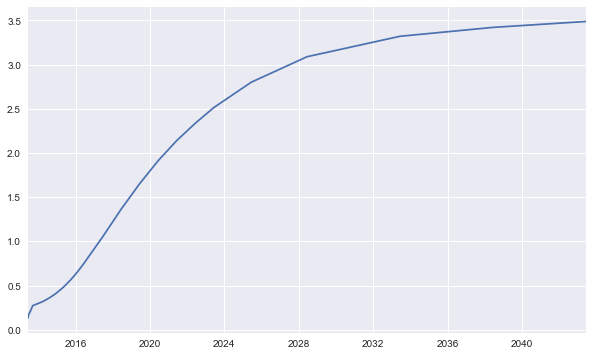

In [134]:
libf[startdate].plot(figsize=(10, 6))

## Model Calibration

Next, equipped with the Libor data, we calibrate the **square-root diffusion short rate model**. A bit of data preparation:

In [136]:
t = libf.index
f = libf[startdate].values / 100
initial_value = 0.005

A **mean-squared error (MSE)** function to be minimized during calibration.

In [137]:
def srd_forward_error(p0):
    global initial_value, f, t
    if p0[0] < 0 or p0[1] < 0 or p0[2] < 0:
        return 100
    f_model = dx.srd_forwards(initial_value, p0, t)
    MSE = np.sum((f - f_model) ** 2) / len(f)
    return MSE

And the **calibration** itself.

In [138]:
from scipy.optimize import fmin

In [227]:
opt = fmin(srd_forward_error, (4.0, 2.0, 0.2),
           maxiter=1000, maxfun=1000)

Optimization terminated successfully.
         Current function value: 0.000009
         Iterations: 354
         Function evaluations: 630


The **optimal parameters** (kappa, theta, sigma) are:

In [238]:
opt

array([4.20596812e-04, 9.62048126e+00, 7.18982609e-02])

The **model fit** is not too bad in this case.

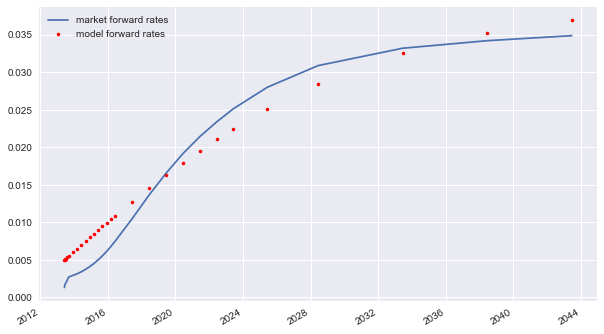

In [239]:
plt.figure(figsize=(10, 6))
plt.plot(t, f, label='market forward rates')
plt.plot(t, dx.srd_forwards(initial_value, opt, t), 'r.', label='model forward rates')
plt.gcf().autofmt_xdate(); plt.legend(loc=0)

## Floating Rate Modeling

The optimal parameters from the calibration are used to model the **floating rate (3m Libor rate)**.

In [348]:
# market environment
me_srd = dx.market_environment('me_srd', dt.datetime(2013, 6, 12))

In [349]:
# square-root diffusion
me_srd.add_constant('initial_value', 0.0136)
me_srd.add_constant('kappa', opt[0]) 
me_srd.add_constant('theta', opt[1])
me_srd.add_constant('volatility', opt[2])
me_srd.add_curve('discount_curve', ois)
  # OIS discounting object
me_srd.add_constant('currency', 'USD')
me_srd.add_constant('paths', 10000)
me_srd.add_constant('frequency', 'w')
me_srd.add_constant('starting_date', me_srd.pricing_date)
me_srd.add_constant('final_date', dt.datetime(2018, 6, 12))

In [350]:
srd = dx.square_root_diffusion('srd', me_srd)

Let us have a look at some **simulated rate paths**.

In [351]:
paths = srd.get_instrument_values()

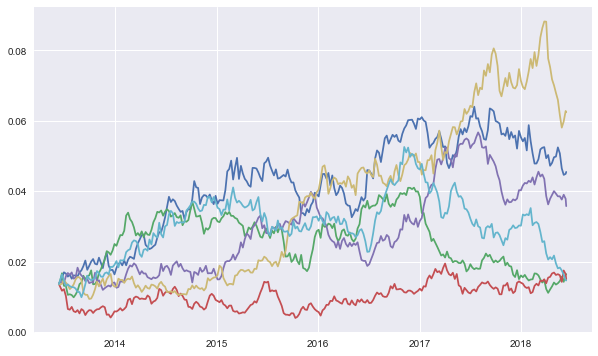

In [352]:
plt.figure(figsize=(10, 6))
plt.plot(srd.time_grid, paths[:, :6])

## Interest Rate Swap

Finally, we can model the **interest rate swap** itself.

### Modeling

First, the market environment with all the **parameters** needed.

In [359]:
# market environment for the IRS
me_irs = dx.market_environment('irs', me_srd.pricing_date)
me_irs.add_constant('fixed_rate', 0.0136)
me_irs.add_constant('trade_date', me_srd.pricing_date)
me_irs.add_constant('effective_date', me_srd.pricing_date)
me_irs.add_constant('payment_date', dt.datetime(2014, 6, 12))
me_irs.add_constant('payment_day', 12)
me_irs.add_constant('termination_date', me_srd.get_constant('final_date'))
me_irs.add_constant('currency', 'USD')
me_irs.add_constant('notional', 100000)
me_irs.add_constant('tenor', '6m')
me_irs.add_constant('counting', 'ACT/360')
# discount curve from mar_env of floating rate

The instantiation of the **valuation object**.

In [360]:
irs = dx.interest_rate_swap('irs', srd, me_irs)

### Valuation

The **present value** of the interest rate swap given the assumption, in particular, of the fixed rate.

In [361]:
%time irs.present_value(fixed_seed=True)

Wall time: 2.26 s


8687.195825461085

You can also generate a **full output of all present values** per simulation path.

In [362]:
irs.present_value(full=True).iloc[:, :6]

,0,1,2,3,4,5
2014-06-12,1655.165758,1948.293100,-303.121311,386.798609,75.234792,1283.615171
2014-12-12,2349.635778,1823.504167,-430.039325,269.483901,307.228277,2171.821179
2015-06-12,3483.403368,1456.907423,93.874347,1503.900535,749.112444,1437.376843
2015-12-12,2775.403647,1392.016817,-780.920852,1955.666510,3071.145582,1926.812320
2016-06-12,2765.142231,2036.596171,-432.532706,926.096866,2903.903455,1513.333117
2016-12-12,4320.538769,1723.744708,-55.102127,2354.324421,3089.188249,3095.322391
2017-06-12,4433.470996,476.595017,-159.274764,4071.434487,5326.368460,1948.025863
2017-12-12,4024.800467,158.866013,-252.734539,2735.217342,6152.208780,2373.927862


**Copyright, License & Disclaimer**

© Dr. Yves J. Hilpisch | The Python Quants GmbH

DX Analytics (the "dx library" or "dx package") is licensed under the GNU Affero General
Public License version 3 or later (see http://www.gnu.org/licenses/).

DX Analytics comes with no representations or warranties, to the extent
permitted by applicable law.

http://tpq.io | [dx@tpq.io](mailto:team@tpq.io) |
http://twitter.com/dyjh

<img src="http://hilpisch.com/tpq_logo.png" alt="The Python Quants" width="35%" align="right" border="0"><br>

**Quant Platform** | http://pqp.io

**Python for Finance Training** | http://training.tpq.io

**Certificate in Computational Finance** | http://compfinance.tpq.io

**Derivatives Analytics with Python (Wiley Finance)** |
http://dawp.tpq.io

**Python for Finance (2nd ed., O'Reilly)** |
http://py4fi.tpq.io